# Poisson equation in a multipatch domain

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 15),)

In [3]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-pi/2).translate((-2, 1))
]

patches = [(kvs, g) for g in geos]

setting up constraints took 0.006209373474121094 seconds.
Basis setup took 0.022143125534057617 seconds


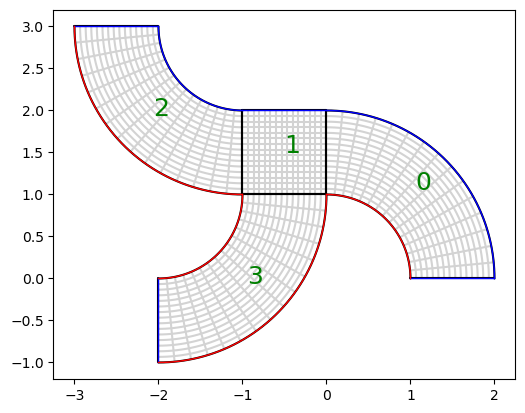

In [4]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: exp(-5 * ((x-0.3)**2 + (y-1)**2))
g0 = lambda x, y: 1e-1 * sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
g1 = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({1:{(0,2),(2,3),(3,2),(3,3)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.draw(patch_idx = True, knots=True, bcolor={0:'blue',1:'red'})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
A, rhs = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)

# generate Dirichlet data for global boundary dofs
dir_bcs = MP.compute_dirichlet_bcs({0:g0})

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
N = MP.assemble_surface('(g1 * v) * ds', arity=1, g1=g1, boundary_idx=1)

#generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
R = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx=1)

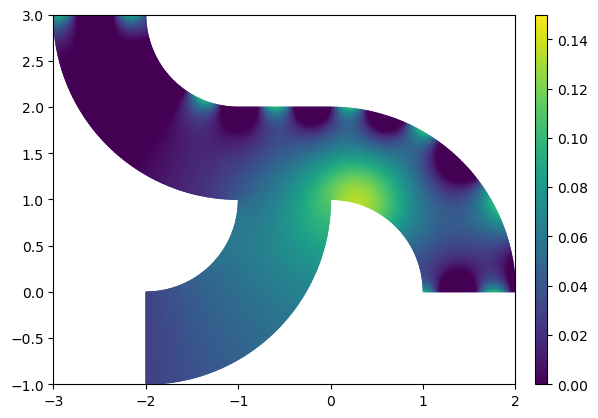

In [5]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(A + R, rhs + N, dir_bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch (kvs on every patch) and visualize solution
MP.plot(u, range = (0, 1.5e-1), cmap='viridis')